# Dataset [Special Store-Item Demand Forecasting](https://www.kaggle.com/code/blirinddanjolli/special-store-item-demand-forecasting/inputhttps://www.kaggle.com/code/blirinddanjolli/special-store-item-demand-forecasting/input)

* date - дата
* store - id магазина
* item - id товара
* sales - количество продаж

In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("train.csv", parse_dates=["date"])
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
# выберем только первый магазин и первый товар
store = 1
item = 1
data = data[(data["store"] == store) & (data["item"] == item)]
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
# дату устанавливаем как индекс
data = data.set_index("date")
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [5]:
# выделим данные о продажах
data = data["sales"]
data.head()

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

In [6]:
# Разделим данные на треин и тест
# предстказываем продажи на год вперед
test_size = 365
data_train = data.iloc[:-test_size]
data_test = data.iloc[-test_size:]

In [7]:
data_train.shape

(1461,)

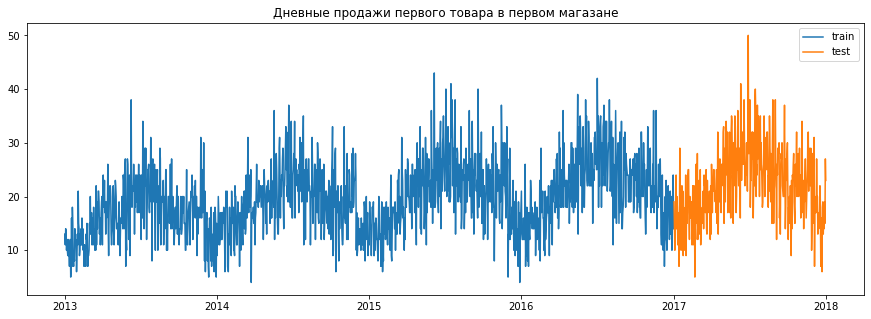

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.title("Дневные продажи первого товара в первом магазане")
plt.plot(data_train, label="train")
plt.plot(data_test, label="test")
plt.legend();

In [9]:
# data_train[:364].shape

<a list of 2 Line2D objects>

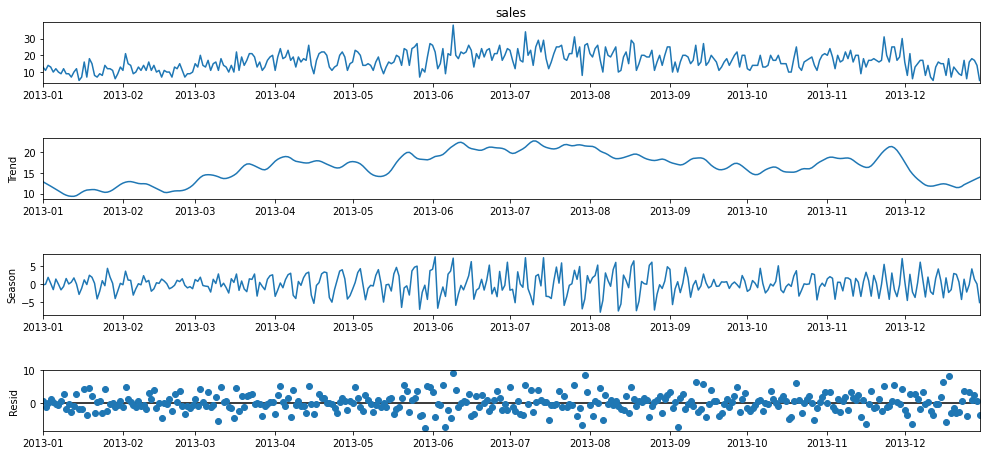

In [10]:
# Видно что данные обладают годичной сезонностью. 
# Посмотрим теперь, есть ли недельная сезонность.
from statsmodels.tsa.seasonal import STL

result = STL(data_train[:364], period=7).fit()

# import matplotlib as mpl
# mpl.rcParams["figure.figsize"] = 15, 7
# result.plot()

fig = result.plot()
fig.set_figheight(7)
fig.set_figwidth(15)
fig.gca().get_lines() #[2].set_color('red') # Например, установим цвет красным для сезонной составляющей

In [11]:
# Недельная сезонность есть, но с некоторым шумом

# Метрики

In [12]:
# Напишем функцию которая будет считать качество моделей
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

compare_table = None

def add_results_in_comprasion_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Дабавляет новуб строчку в таблицу compare_table
    с результатами текущей модели
    
    Если ранее модель была уже добавлена в таблицу, 
    то старая строчка перезапишется на новую.
    
    Параметры:
    - method: имя модели
    - y_true: истинные значения
    - y_forecast: предсказанные значения
    """
    
    global compare_table
    
    # считаем метрики
    result_row = {
        "method" : method,
        "MSE" : mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE" : mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE" : mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast),
    }
    
    # записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table["method"]):
            compare_table = compare_table[compare_table["method"] != method]
        
        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
        
    return compare_table
                                   

# Простая модель / baseline

In [13]:
# Пусть модель будет считает среднее за каждый год с учетом дней недели
# Полученное среднее как раз будет являтьс прогнозом на будущее

temp_data = pd.DataFrame(data_train)

In [14]:
# выделяем день недели

# temp_data["weekofyear"] = data_train.index.weekofyear
temp_data["weekofyear"] = data_train.index.isocalendar().week 

temp_data["dayofweek"] = data_train.index.dayofweek



In [15]:
temp_data

,sales,weekofyear,dayofweek
date,,,
2013-01-01,13,1,1
2013-01-02,11,1,2
2013-01-03,14,1,3
2013-01-04,13,1,4
2013-01-05,10,1,5
...,...,...,...
2016-12-27,10,52,1
2016-12-28,16,52,2
2016-12-29,21,52,3


In [16]:
# группируем данные по номеру недели и по номеру дня на неделе
mean_sales = temp_data.groupby(["weekofyear", "dayofweek"])["sales"].mean()
display(mean_sales)

weekofyear  dayofweek
1           0             8.666667
            1            12.750000
            2            12.000000
            3            12.750000
            4            13.750000
                           ...    
53          2            15.000000
            3            18.000000
            4            21.000000
            5            13.000000
            6            12.000000
Name: sales, Length: 371, dtype: float64

In [17]:
simple_prediction = []

for index in data_test.index:
    simple_prediction.append(
        mean_sales.loc[(index.weekofyear, index.dayofweek)]
    )

In [18]:
# simple_prediction

In [19]:
# отобразим полученнны результаты
def plot_results(y_to_train, y_to_test, y_forecast):
    """
    Функция для визуализации временного ряда и предсказания.
    Параметры:
    - y_to_train: pd.Series
            Временной ряд, на котором обучалась модель 
    - y_to_test: pd.Series
            Временной ряд, который предсказывает модель
    - y_forecast: array
            Предсказания модели
    - plot_conf_int: bool
            Надо ли строить предсказательный интервал
    - left_bould: array
            Левая граница предсказательного интервала
    - right_bould: array
            Правая граница предсказательного интервала
    """
    plt.figure(figsize=(15, 5))
    plt.title("Дневные продажи объекта 1 в магазине 1", fontsize=15)
    plt.plot(y_to_train, label="train")
    plt.plot(y_to_test, label="test")
    plt.plot(y_to_test.index, y_forecast, label="prediction")
    plt.legend()
    plt.show()

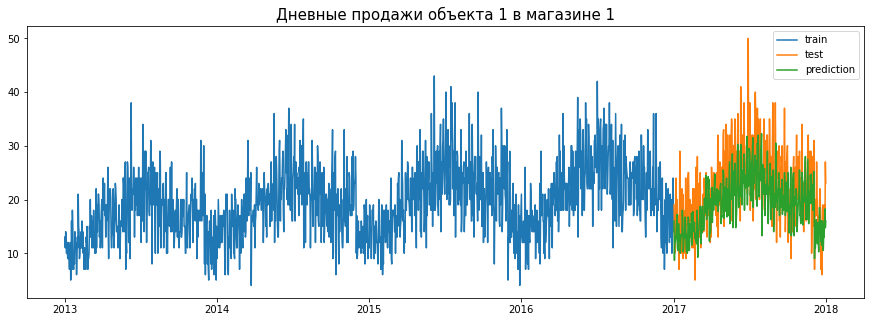

In [20]:
plot_results(data_train, data_test, simple_prediction)

In [21]:
add_results_in_comprasion_table("SimpleModel", data_test, simple_prediction)

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949


In [22]:
# явно видно что не совпало среднее поскольку не учтен тренд

# Работа с признаками

In [23]:
# преобразуем дату, выделим день, месяц, год и тд

def create_date_features(date):
    """Создает фичи из даты"""
    
    row = {}
    row["dayofweek"] = date.dayofweek
    row["quarter"] = date.quarter
    row["month"] = date.month
    row["year"] = date.year
    row["dayofyear"] = date.dayofyear
    row["dayofmonth"] = date.day
    row["weekofyear"] = date.weekofyear
    return row

In [24]:
# создадим датасет для обучения
# функция извлечения фичи из даты для каждой строчки таблицы

def create_only_date_train_features(y_series):
    """
    Создает обучающий датает из признаков, полученных из дат для y_series
    """
    time_features = pd.DataFrame(
        [create_date_features(date) for date in y_series.index]
    )
    return time_features, y_series

In [25]:
X_train, y_train = create_only_date_train_features(data_train)

In [26]:
display(X_train.head())

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,1,1,2013,1,1,1
1,2,1,1,2013,2,2,1
2,3,1,1,2013,3,3,1
3,4,1,1,2013,4,4,1
4,5,1,1,2013,5,5,1


In [27]:
display(y_train.head())

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

# Регрессионное предсказание


In [28]:
def recursive_prediction(model, test_dates, y_to_train, features_creation_functoin):
    """
    Функция рекурсивного предсказани для дат,
    указанных в test_dates
    - model: мл-модель
    - test_dates: массив с датами, в которые надо сделать предсказания
    - y_to_train: 
    - features_creation_functoin: функция для создания тестовых признаков
    """
    predictions = []
    previous_y = list(y_to_train)
    for date in test_dates:
        
        # выделяет признаки и добавляет к предыдущму y - previous_y)
        row = features_creation_functoin(date, previous_y)
        
        curr_test = pd.DataFrame([row])
        curr_prediction = model.predict(curr_test)[0]
        previous_y.append(curr_prediction)
        predictions.append(curr_prediction)
        
    return np.array(predictions)    

### Попробуем обучить на RandomForest

In [29]:
from sklearn.ensemble import RandomForestRegressor

# %%time
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [30]:
# получим предсказания
random_forest_prediction = recursive_prediction(
    model=rf, 
    test_dates=data_test.index,
    y_to_train=data_train,
    features_creation_functoin=lambda date, previous_y: create_date_features(date),
)

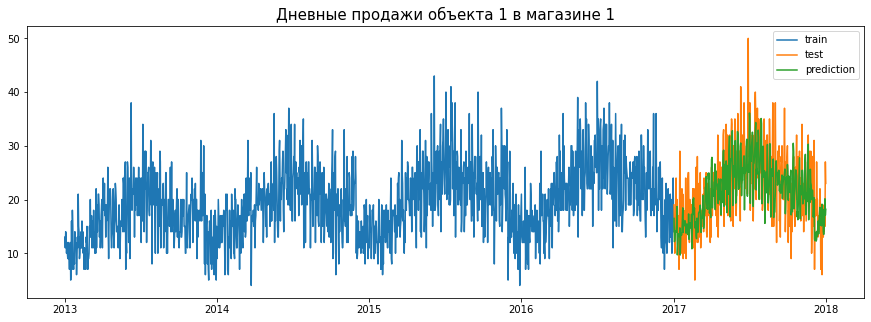

In [31]:
plot_results(data_train, data_test, random_forest_prediction)

In [32]:
add_results_in_comprasion_table("RandomForest", data_test, random_forest_prediction)

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185


### Попробуем CatBoost


In [33]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [34]:
from catboost import CatBoostRegressor 

catboost_ = CatBoostRegressor()
catboost_.fit(X_train, y_train, verbose=False)

In [35]:
# по умолчанию использует 1000 деревьев
catboost_.tree_count_

1000

In [36]:
catboost_predictions = recursive_prediction(
    catboost_,
    data_test.index,
    data_train,
    lambda date, previous_y: create_date_features(date),
)

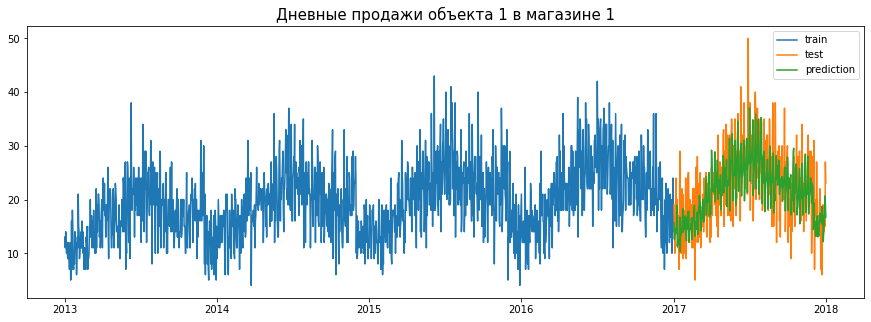

In [37]:
plot_results(data_train, data_test, catboost_predictions)

In [38]:
add_results_in_comprasion_table("Catboost", data_test, catboost_predictions)

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,Catboost,25.423261,4.037769,0.207164


# Использование исторических данных

In [39]:
# добавим сдвиги по времени

def create_date_and_shifted_train_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат и значений ряда ранее
    При этом используются значения ряда со сдвигами на неделю и год назад
    - y_seties: временной ряд
    - shift: днйвной сдвиг
    - week_seasonal_shifts: недельный сдвиг
    - year_seasonal_shifts: годовой сдвиг
    """
    curr_df, y = create_only_date_train_features(y_series)
    curr_df.index = y_series.index
    
    # применяем сдвиг по дням
    for shift in range(1, shifts + 1):
        curr_df[f"shift_{shift}"] = y_series.shift(shift, axis=0)   
    
    # применяем сдвиг по неделям
    for shift in range(1, week_seasonal_shifts + 1):
        curr_df[f"week_seasonal_shift_{shift}"] = y_series.shift(shift * 7, axis=0)  
        
    # применяем сдвиг по годам
    for shift in range(1, year_seasonal_shifts + 1):
        curr_df[f"year_seasonal_shifts_{shift}"] = y_series.shift(shift * 365, axis=0)
        
    y = y_series
    
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

In [40]:
# Зададим функцию чтобы получать аналогичные признаки на тесте

def date_and_shift_features_generator_for_test(date, previous_y):
    """Функция создания признаков из дат и сдвигов ряда для тестовых дат"""
    
    row = create_date_features(date)
    for shift in range(1, SHIFT + 1):
        row[f"shift_{shift}"] = previous_y[-1 * shift]
    for shift in range(1, WEEK_SHIFT + 1):
        row[f"week_seasonal_shift_{shift}"] = previous_y[-1 * shift * 7]
    for shift in range(1, YEAR_SHIFT + 1):
        row[f"year_seasonal_shifts_{shift}"] = previous_y[-1 * shift * 365]
    return row

In [41]:
SHIFT = 1 # дней назад
WEEK_SHIFT = 2 # недель назад
YEAR_SHIFT = 1 # лет назад

In [42]:
# Получим новые признаки
X_train, y_train = create_date_and_shifted_train_features(
    data_train,
    shifts = SHIFT,
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT,
)

In [43]:
X_train.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,shift_1,week_seasonal_shift_1,week_seasonal_shift_2,year_seasonal_shifts_1
date,,,,,,,,,,,
2014-01-01,2,1,1,2014,1,1,1,15.0,6.0,18.0,13.0
2014-01-02,3,1,1,2014,2,2,1,9.0,16.0,7.0,11.0
2014-01-03,4,1,1,2014,3,3,1,14.0,18.0,13.0,14.0
2014-01-04,5,1,1,2014,4,4,1,11.0,17.0,11.0,13.0
2014-01-05,6,1,1,2014,5,5,1,20.0,14.0,9.0,10.0


In [44]:
rf = RandomForestRegressor(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# получим предсказания
random_forest_prediction = recursive_prediction(
    rf, 
    data_test.index,
    data_train,
    date_and_shift_features_generator_for_test
)

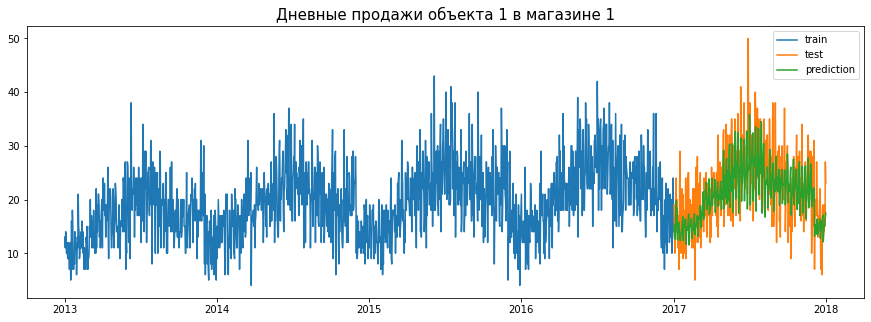

In [45]:
plot_results(data_train, data_test, random_forest_prediction)

In [46]:
add_results_in_comprasion_table("RandomForest + shift features", 
                                data_test, 
                                random_forest_prediction)

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,Catboost,25.423261,4.037769,0.207164
3,RandomForest + shift features,26.361437,4.074438,0.201246


In [47]:
catboost_ = CatBoostRegressor()
catboost_.fit(X_train, y_train, verbose=False)

catboost_predictions = recursive_prediction(
    catboost_,
    data_test.index,
    data_train,
    date_and_shift_features_generator_for_test
)

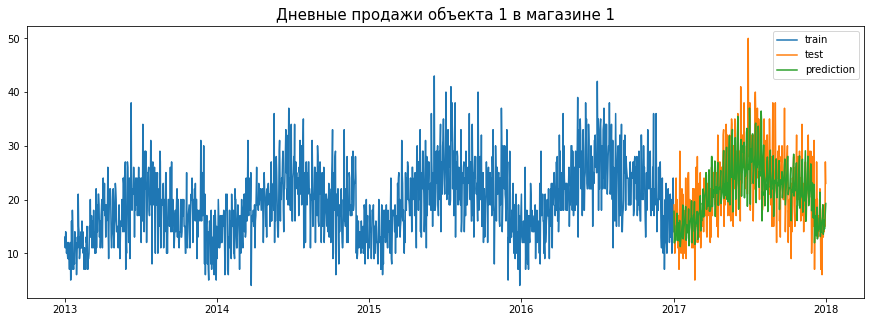

In [48]:
plot_results(data_train, data_test, catboost_predictions)

In [49]:
add_results_in_comprasion_table("CatBoost + shift features", 
                                data_test, 
                                catboost_predictions)

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,Catboost,25.423261,4.037769,0.207164
3,RandomForest + shift features,26.361437,4.074438,0.201246
4,CatBoost + shift features,24.041947,3.938117,0.197173


# Добавим признаки скользящего среднего

In [50]:
def create_date_shifted_and_rolling_train_features(
    y_series, shifts=5, week_seasonal_shifts=1, year_seasonal_shifts=1
):
    """
    Создает обучающий датасет из признаков, полученных из дат 
    и значений ряда заранее.
    Используются значения ряда со сдвигами на неделю и год назад.
    Также добавлены признаки скользящего среднего.
    Параметры:
    - y_series: временной ряд
    - shifts: дневной сдвиг
    - week_seasonal_shifts: недельный сдвиг
    - year_seasional_shifts: годовой сдвиг
    """
    curr_df, y = create_date_and_shifted_train_features(
        y_series,
        shifts=shifts,
        week_seasonal_shifts=week_seasonal_shifts,
        year_seasonal_shifts=year_seasonal_shifts
    )
    
    # Значения скользящего окна надо сдвинуть на 1 вправо
    # иначе будет при обучение текущее значние ряда
    
    # берем текущее значение с константой альфа
    # и предыдущее сглаженное занчение с константой 1-альфа
    
    curr_df["rolling_mean"] = (
        y_series.rolling(shifts, min_periods=1).mean().shift(1, axis=0)
    )
    curr_df["rolling_max"] = (
        y_series.rolling(shifts, min_periods=1).max().shift(1, axis=0)
    )
    curr_df["rolling_min"] = (
        y_series.rolling(shifts, min_periods=1).min().shift(1, axis=0)
    )
    # удалим первые строчки с nan
    drop_indices = curr_df.index[curr_df.isna().sum(axis=1) > 0]
    curr_df = curr_df.drop(index=drop_indices)
    y = y.drop(index=drop_indices)
    return curr_df, y

In [51]:
def date_shifted_and_rolling_features_generator_for_test(date, previous_y):
    """
    Функция создания признаков из дат и сдвигов ряда для тестовых дат
    """
    row = date_and_shift_features_generator_for_test(date, previous_y)
    row["rolling_mean"] = np.mean(previous_y[-SHIFT:])
    row["rolling_max"] = np.max(previous_y[-SHIFT:])    
    row["rolling_min"] = np.min(previous_y[-SHIFT:])   
    return row

In [52]:
# Новые признаки
X_train, y_train = create_date_shifted_and_rolling_train_features(
    data_train, 
    shifts=SHIFT,
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT,
)

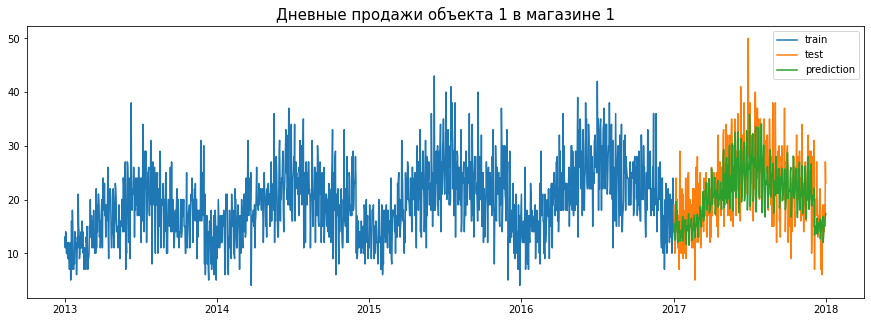

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,Catboost,25.423261,4.037769,0.207164
3,RandomForest + shift features,26.361437,4.074438,0.201246
4,CatBoost + shift features,24.041947,3.938117,0.197173
5,RandomForest + advanced features,26.648751,4.072292,0.199721


In [53]:
# RamdomForest
random_forest = RandomForestRegressor(n_estimators=300, random_state=42)
random_forest.fit(X_train, y_train)

# получим предсказания
random_forest_prediction = recursive_prediction(
    random_forest, 
    data_test.index,
    data_train,
    date_shifted_and_rolling_features_generator_for_test
)

plot_results(data_train, data_test, random_forest_prediction)

add_results_in_comprasion_table("RandomForest + advanced features", 
                                data_test, 
                                random_forest_prediction)

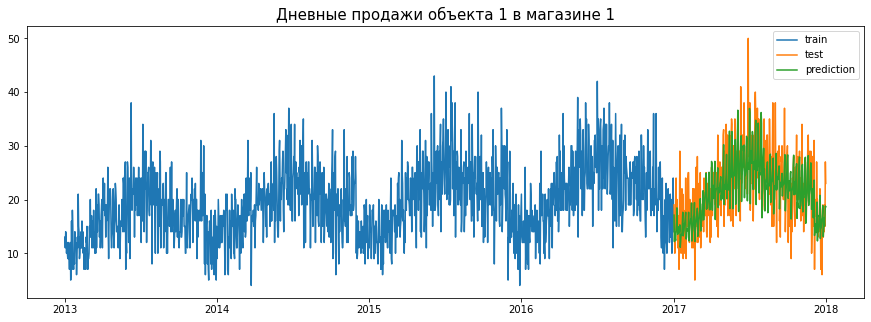

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,Catboost,25.423261,4.037769,0.207164
3,RandomForest + shift features,26.361437,4.074438,0.201246
4,CatBoost + shift features,24.041947,3.938117,0.197173
5,RandomForest + advanced features,26.648751,4.072292,0.199721
6,CatBoost + advanced features,24.205633,3.950824,0.199155


In [54]:
catboost = CatBoostRegressor()
catboost.fit(X_train, y_train, verbose=False)

# получим предсказания
catboost_predictions = recursive_prediction(
    catboost, 
    data_test.index,
    data_train,
    date_shifted_and_rolling_features_generator_for_test
)

plot_results(data_train, data_test, catboost_predictions)

add_results_in_comprasion_table("CatBoost + advanced features", 
                                data_test, 
                                catboost_predictions)

# Подбор гиперпараметров

In [55]:
# для CatBoost + shifted features

X_train, y_train = create_date_and_shifted_train_features(
    data_train, 
    shifts=SHIFT,
    week_seasonal_shifts=WEEK_SHIFT,
    year_seasonal_shifts=YEAR_SHIFT,
)

In [56]:
# Задаем сетку параметров
random_grid = {
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [200, 400, 600, 800, 1000, 1200]
}

In [57]:
cv = [
    [np.arange(0, 365), np.arange(365, 365 * 2)],
    [np.arange(0, 365 * 2), np.arange(365 * 2, 365 * 3)]
]

In [58]:
# используем RandomizedSearchCV для подбора гиперпараметров
from sklearn.model_selection import RandomizedSearchCV


ctb = CatBoostRegressor(verbose=False)

ctb_random = RandomizedSearchCV(
    estimator=ctb,
    param_distributions=random_grid,
    n_iter=100,
    cv=cv,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=4,
    verbose=False
)

ctb_random.fit(X_train, y_train)
ctb_random.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_estimators': 200, 'learning_rate': 0.05, 'depth': 6}

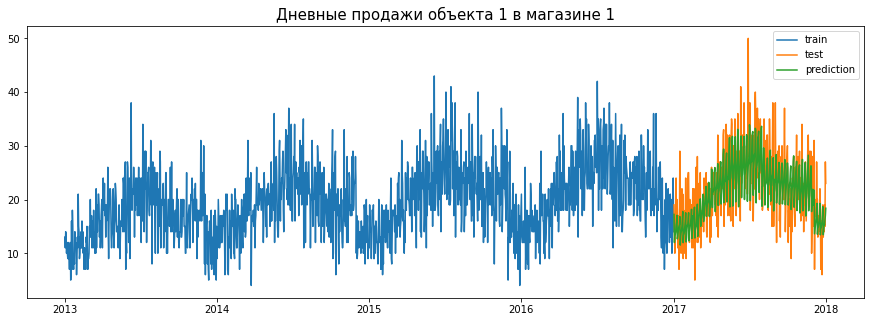

,method,MSE,MAE,MAPE
0,SimpleModel,34.553044,4.696804,0.217949
1,RandomForest,28.042948,4.179479,0.212185
2,Catboost,25.423261,4.037769,0.207164
3,RandomForest + shift features,26.361437,4.074438,0.201246
4,CatBoost + shift features,24.041947,3.938117,0.197173
5,RandomForest + advanced features,26.648751,4.072292,0.199721
6,CatBoost + advanced features,24.205633,3.950824,0.199155
7,CatBoost + shift features + cv,22.999645,3.820161,0.193361


In [59]:
cv_shifted_features_catboost = ctb_random.best_estimator_

cv_shifted_features_catboost_prediction = recursive_prediction(
    cv_shifted_features_catboost, 
    data_test.index,
    data_train,
    date_shifted_and_rolling_features_generator_for_test
)

plot_results(data_train, data_test, cv_shifted_features_catboost_prediction)

add_results_in_comprasion_table("CatBoost + shift features + cv", 
                                data_test, 
                                cv_shifted_features_catboost_prediction)